# Lensed QSO work with Gaia DR2

Using the LQSO Castle match with DR2 as the learning set and apply this to LQSO allwise 2.

Trying with machine learning classification.

The idea is to use the following set of _features_ for each LQSO:

* the total proper motion and its error
* the total parallax and its error
* the astrometric colour
* the distances to the nearest 3 neighbours.

This makes 6 _features_ to feed to the SVM/PCA classification.


In [1]:
import os
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn import svm, tree
#from IPython.display import Math

D2R = np.pi/180.0

wdir = os.path.expanduser('~') + '/Dropbox/Work/Gaia-QSO'

In [3]:
# read the Castle xmatch with DR2
url1 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
t = Table.read(url1,format='votable')
nt = len(t)
# the total pm
mu = np.sqrt(t['pmra']**2 + t['pmdec']**2)
# propagate the errors, assuming pmra_error and pmdec_errors are uncorrelated
mu_error = np.sqrt((t['pmra']*t['pmra_error']/mu)**2 + (t['pmdec']*t['pmdec_error']/mu)**2)
#
t['mu'] = mu
t['mu_error'] = mu_error
#
print ("Total number of LQSO is {}".format(nt))


Total number of LQSO is 87


/Users/ivaltchanov/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ivaltchanov/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([20., 21.,  8.,  6.,  2.,  1.,  3.,  2.,  2.,  2.]),
 array([0.01236125, 0.03630084, 0.06024043, 0.08418001, 0.1081196 ,
        0.13205919, 0.15599877, 0.17993836, 0.20387795, 0.22781753,
        0.25175712]),
 <a list of 10 Patch objects>)

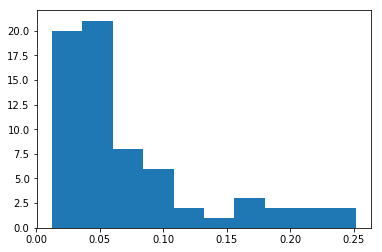

In [8]:
plt.hist(t['astrometric_pseudo_colour_error'])

In [38]:
#
# now calculate the nearest neighbour and the 3rd nearest neighbour to each source
# using BallTree
#
#
# build the tree
#
X = np.array([t['ra']*D2R,t['dec']*D2R]).transpose()
# metric haversine is the distance on a sphere
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
#tree = BallTree(X,leaf_size=10,metric="haversine")
distances, indices = nbrs.kneighbors(X)

In [40]:
#
# add the distances to the nearest 3 neighbours in table
t["n1"] = distances[:,1]
t["n2"] = distances[:,2]
t["n3"] = distances[:,3]
#

## Machine learning approach

Will try different methods to learn from the LQSO and apply it to the simulated catalogue


In [44]:
X = np.array([t["mu"],t["mu_error"],t["parallax"],t["parallax_error"],t["astrometric_pseudo_colour"],\
              t["n1"],t["n2"],t["n3"]]).transpose()
#
# the shape should be (n_samples, n_features)
y = np.zeros(nt,dtype=np.uint8)
y[i_lqso] = 1

In [46]:
# run multiple times (10) with subsets of 1000 QSO and STAR sources
#
# make a small subset, use all LQSO but just 1000 QSO and 1000 STAR, random select 1000 indices
#
nruns = 100
nr_lqso = 100
nr_qso = 1000
nr_star = 1000
nx1 = []
nx2 = []
nx3 = []
for jrun in np.arange(nruns):
    isub = np.hstack([np.random.choice(i_lqso,size=nr_lqso),np.random.choice(i_qso,size=nr_qso),np.random.choice(i_star,size=nr_star)])
    Xp = X[isub,:]
    yp = y[isub]
    #clf = svm.SVC()
    clf = tree.DecisionTreeClassifier()
    clf.fit(Xp, yp)
    nx1.append(len(np.where(clf.predict(X[i_lqso,:]) == 1)[0]))
    nx2.append(len(np.where(clf.predict(X[i_qso,:]) == 1)[0]))
    nx3.append(len(np.where(clf.predict(X[i_star,:]) == 1)[0]))
    pass
print ("Results after {} random selections of {} LQSO, {} QSO and {} STARs".format(nruns,nr_lqso,nr_qso,nr_star))
print ("LQSO classified as LQSO: {}, ({:.1f} %)".format(np.mean(nx1),100*np.mean(nx1)/nlens))
print ("QSO classified as LQSO: {}, ({:.1f} %)".format(np.mean(nx2),100*np.mean(nx2)/nqso))
print ("STARs classified as LQSO: {}, ({:.1f} %)".format(np.mean(nx3),100*np.mean(nx3)/nstar))


Results after 100 random selections of 100 LQSO, 1000 QSO and 1000 STARs
LQSO classified as LQSO: 236.03, (90.8 %)
QSO classified as LQSO: 2534.4, (0.6 %)
STARs classified as LQSO: 85.59, (0.4 %)
